# Homework 6
Use the Gyro data to find times when the image is not moving (or is moving less than a threshold velocity in both horizontal and vertical dimensions). Train a ConvLSTM2D network (you can use the Model2 structure, or a different structure if you prefer). The network should predict whether the camera is moving or not. The network should have two outputs: one that is 1 when the image is moving, the other is 1 when the image is not moving. This is a "one-hot" coding for movement. Note that this is a binary (categorical) one-hot encoded variable so choose the correct output encoding and loss function.

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Width = 640, Height = 360, Colors = 3
Read 1846 frames


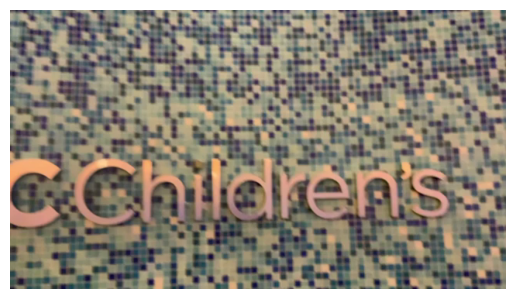

In [136]:
#The usual preamble
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import cv2
from moviepy.editor import *
import tensorflow as tf

#for your homework
np.random.seed(57999719)
tf.random.set_seed(57999719)

from google.colab import drive
drive.mount('/content/drive')


#######         Upload and Preprocess CHOC Video      ##############

video_filename = '/content/drive/MyDrive/Colab Notebooks/CHOCVideo2.mov'
video_reader = cv2.VideoCapture(video_filename)
_, bgr_frame = video_reader.read()
rgb_frame = cv2.cvtColor(bgr_frame, cv2.COLOR_BGR2RGB)
#convert to RGB order for processing
plt.imshow(rgb_frame)
plt.axis('off')
orig_width = bgr_frame.shape[1]
orig_height = bgr_frame.shape[0]
ncolors = bgr_frame.shape[2]
image_width = 128
image_height = int(orig_height * image_width / orig_width)
#proportional scaling to preserve aspect ratio
print(f'Width = {orig_width}, Height = {orig_height}, Colors = {ncolors}')

#this time we are going to convert to grayscale,
#and we will only use one image at a time
#we don't need to concatenate x(t) & x(t+1) because we will let
#the LSTM network handle the changes with time.
frames_list = []
nframes = 0
cvt_gray = [0.2989, 0.5870, 0.1140]
# these are standard ratios for converting RGB to grayscale

while True:
  success, bgr_frame = video_reader.read()
  if not success:
     break
  rgb_frame = cv2.cvtColor(bgr_frame, cv2.COLOR_BGR2RGB) #RGB color conversion
  gray_frame = np.dot(rgb_frame, cvt_gray)
  #dot() operator works on the last dimension
  resized_frame = cv2.resize(gray_frame, (image_width, image_height))
  #resize and smooth to make smaller
  normalized_frame = resized_frame / 255
  frames_list.append(normalized_frame)
  nframes +=1
video_reader.release()
print(f'Read {nframes} frames')

(1837, 2)

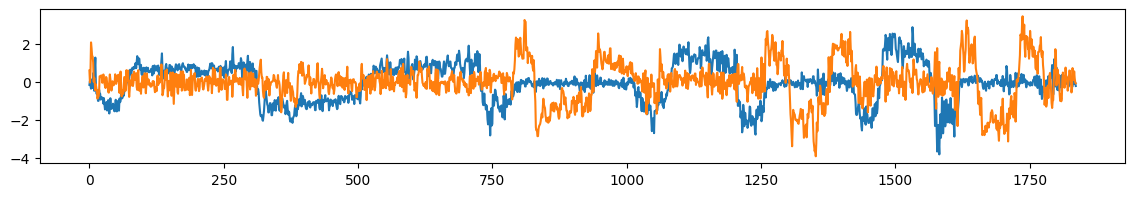

In [137]:
#######         Upload and Preprocess Gyro Data      ##############

dfGyro = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/gyro.csv')
dfGyro = dfGyro.rename(columns={
    'Time' : 't',
    ' Rotation Rate (X)' : 'wx',
    ' Rotation Rate (Y)' : "wy",
    ' Rotation Rate (Z)' : "wz"})
#data record at 30Hz, which is same as video frame rate
dfGyro['t'] = dfGyro['t'] - dfGyro['t'][0]
#set the initial time to be zero

#predict both the horizontal and vertical gyro
desired_output_horizontal = dfGyro['wy'] / dfGyro['wy'].std()
#normalize between -1 to 1 approx, so the network can learn
desired_output_vertical = dfGyro['wx'] / dfGyro['wx'].std()
desired_output = np.vstack((desired_output_horizontal.values,
                            desired_output_vertical.values)).transpose() #make column-wise

#make a list of the video frames that has the timestamps
nTimes, nOutputs = desired_output.shape
#in this case, the gyro data is slightly shorter than the video data
frames_list = frames_list[:nTimes]  #trim the video to be exactly the length of the gyro
#to be safe, I checked 1st that the video len & gyro data length were the same;
#never trust the stated frame rate
imSeries = pd.Series(data=frames_list, index=dfGyro['t'])
#assigns timestamps to the video data in case we need that, turn it into a Series

plt.figure(figsize=(14,2))
plt.plot(desired_output);
#the gyro data is quite noisy. I don't both filtering it; the network has to figure this out.
desired_output.shape

# Threshold & Conversion to 1 Hot Encoding:
The threshold utilized to determine if the image is moving will be from the gyro data. Since the gyro data has been normalized, values that are greater than 0.5 or less than -0.5 clearly indicate motion. Values closer to zero are more unclear. Thus, a threshold has been set to +/- 0.15, where if the average of the absolute value of the horizontal gyro data added to the absolute value of the vertical gyro data has a magnitude below 0.15, we will classify this as not moving.

One hot encoding will be utilized, where values that fallin within the range specified above will be set to zero, meaning not moving, where values outside of this range will be set to one, meaning moving.

In [138]:
print(desired_output)

[[-0.14203974  0.61433608]
 [ 0.05582077 -0.02093982]
 [-0.18238127  0.59205631]
 ...
 [-0.07146101  0.20568902]
 [-0.02087806 -0.01215516]
 [-0.20259262 -0.05642209]]


In [139]:
#take the absolute value element wise (per ele)
arr_pos = np.absolute(desired_output)
print(arr_pos)

[[0.14203974 0.61433608]
 [0.05582077 0.02093982]
 [0.18238127 0.59205631]
 ...
 [0.07146101 0.20568902]
 [0.02087806 0.01215516]
 [0.20259262 0.05642209]]


In [157]:
threshold = 0.15
moving = np.zeros(nTimes)
for t in range(nTimes):
  moving[t] = (desired_output[t,0] > threshold or desired_output[t,1] > threshold)

In [141]:
encode = np.zeros((len(moving), 2))
encode[moving == 1] = [1, 0]   # moving
encode[moving == 0] = [0, 1]   # not moving
encode = encode.astype(int)
print(encode)

[[1 0]
 [0 1]
 [1 0]
 ...
 [1 0]
 [0 1]
 [0 1]]


# Build CNN-LSTM 2D Model
Now that the true data has been processed and converted we will train the model off of it.

Input: frames from images -- "frames_list"

Output: predicted moving/not moving status -- "encode"

In [142]:
#######         Build Time Series Generator      ##############

from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.callbacks import EarlyStopping

#here we will use the desired_output (horizontal, vertical components of movement from the gyro)
predict_length = 5    #because LSTM will use this sequence
batch_size = 1
training_set_size = int(0.9 * nTimes)
test_set_size = nTimes - training_set_size
gen2 = TimeseriesGenerator(frames_list, encode,
                           length = predict_length, batch_size=batch_size)

training_gen2 = TimeseriesGenerator(frames_list[:training_set_size], encode[:training_set_size,:],
                                    length = predict_length, batch_size=batch_size)

validation_gen2 = TimeseriesGenerator(frames_list[:-test_set_size], encode[:-test_set_size,:],
                                      length = predict_length, batch_size=batch_size)

early_stop = EarlyStopping(monitor='val_loss',patience=2)

#note the shape of the output:  (batch_size, predict_length, height, width, colorchannels)
gen2[100][0].shape

(1, 5, 72, 128)

Model: "model2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 5, 72,     │          0 │ -                 │
│ (InputLayer)        │ 128, 1)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_lstm2d_19      │ (None, 72, 128,   │        736 │ input_layer[0][0] │
│ (ConvLSTM2D)        │ 4)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ average_pooling2d_… │ (None, 8, 14, 4)  │          0 │ conv_lstm2d_19[0… │
│ (AveragePooling2D)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_19          │ (None, 448)       │          0 │ average_pooling2… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense1a (Dense)     │ (None, 20)        │      8,980 │ flatten_19[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense1b (Dense)     │ (None, 20)        │      8,980 │ flatten_19[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense3a (Dense)     │ (None, 1)         │         21 │ dense1a[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense3b (Dense)     │ (None, 1)         │         21 │ dense1b[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_19      │ (None, 2)         │          0 │ dense3a[0][0],    │
│ (Concatenate)       │                   │            │ dense3b[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_10 (Dense)    │ (None, 2)         │          6 │ concatenate_19[0… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 18,744 (73.22 KB)

 Trainable params: 18,744 (73.22 KB)

 Non-trainable params: 0 (0.00 B)

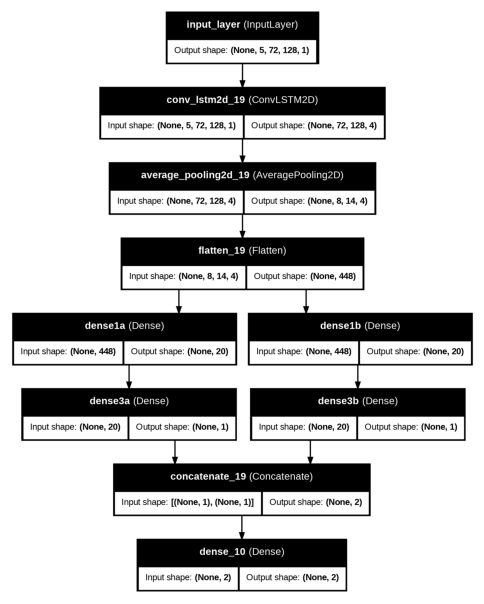

In [143]:
#######         Build CNN-LSTM Model to Process Encoded Gyro      ##############

from tensorflow.python.keras.engine.base_layer_utils import uses_keras_history
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Permute, AveragePooling2D, Concatenate
from tensorflow.keras.layers import Dense, Flatten, Reshape, Conv2D, LayerNormalization, SimpleRNN
from tensorflow.keras.layers import MaxPooling2D, GlobalAveragePooling2D, ConvLSTM2D, LSTM, Input

n_conv_units = 4         #how many different convolution kernels h_i
n_dense_units = 20
n_sensors = 1            #this is now grayscale, so only one channel
n_time_images = predict_length
n_batch = 1

#this time we will use the standard Keras interface. Each layer is linked to the one below programmatically
input_layer = Input(shape=(n_time_images, image_height, image_width, n_sensors), name='input_layer')

#convLSTM2D has n_conv_units outputs for each pixel in the image.
#padding="same" means output image is same size as input
#channels_last data format says this was in the format height, width channels (not channels, height, width)).
time_space_layer = ConvLSTM2D(filters=n_conv_units, kernel_size=(3,3), data_format='channels_last',
                              padding='same', return_sequences=False, activation='linear')(input_layer)

average_layer = AveragePooling2D(pool_size=(9,9), padding = "valid",
                                 data_format = 'channels_last')(time_space_layer)
#sandwich_layer = Dense(n_conv_units, activation = 'sigmoid', name='sandwich')(average_layer)
#average_layer2 = AveragePooling2D(pool_size=(3,3),
#padding = "valid" => disregard edges, data_format = 'channels_last')(sandwich_layer)
flat_layer = Flatten()(average_layer)

#split into two parallel streams
dense1a = Dense(units=n_dense_units, activation='sigmoid', name='dense1a')(flat_layer)
dense1b = Dense(units=n_dense_units, activation='sigmoid', name='dense1b')(flat_layer)
dense3a = Dense(units=1, activation='linear', name='dense3a')(dense1a)
dense3b = Dense(units=1, activation='linear', name='dense3b')(dense1b)
concat = Concatenate(axis=1)([dense3a, dense3b])
finaldense = Dense(units=2, activation='softmax')(concat) #final layer, force softmax
# put the two streams back together so the training data will work as a numpy array
output_layer = finaldense  #the output is the result of the two streams

model2 = Model(inputs = input_layer, outputs = output_layer, name ='model2')
#have to explicitly tell it the inputs and outputs
model2.compile(optimizer='adam', loss='categorical_crossentropy')
model2.summary()

plot_model(model2, to_file='model.png', show_shapes=True, show_layer_names=True)
plt.figure(figsize=(6,8))  # Adjust the figure size as needed
plt.imshow(plt.imread('model.png'))
plt.axis('off')
plt.show()

  self._warn_if_super_not_called()



Epoch 1/5
1648/1648 ━━━━━━━━━━━━━━━━━━━━ 294s 176ms/step - loss: 0.6428 - val_loss: 0.6267
Epoch 2/5
1648/1648 ━━━━━━━━━━━━━━━━━━━━ 291s 177ms/step - loss: 0.6393 - val_loss: 0.6263
Epoch 3/5
1648/1648 ━━━━━━━━━━━━━━━━━━━━ 289s 175ms/step - loss: 0.6176 - val_loss: 0.6127
Epoch 4/5
1648/1648 ━━━━━━━━━━━━━━━━━━━━ 288s 175ms/step - loss: 0.6221 - val_loss: 0.5663
Epoch 5/5
1648/1648 ━━━━━━━━━━━━━━━━━━━━ 287s 174ms/step - loss: 0.5566 - val_loss: 0.5105


<Axes: >

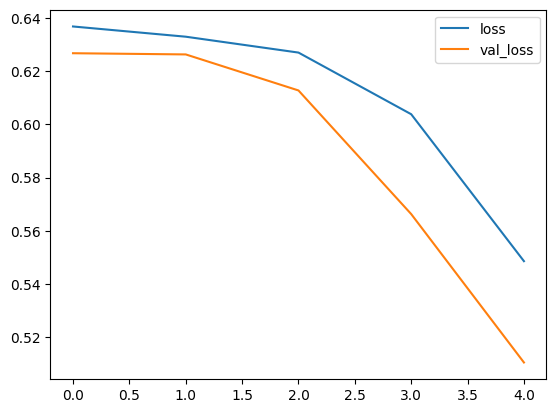

In [144]:
model2.fit(training_gen2,
          epochs=5,
          validation_data=validation_gen2,
          callbacks=[early_stop])
losses = pd.DataFrame(model2.history.history)
losses.plot()

In [145]:
predicted_PMF = model2.predict(gen2)

  self._warn_if_super_not_called()



1832/1832 ━━━━━━━━━━━━━━━━━━━━ 99s 54ms/step


In [148]:
print(predicted_PMF) #output is p(x, t) which consists of 2 states
MLindex = np.argmax(predicted_PMF, axis=1) #axis=1, row wise
MLindex = MLindex.astype(int) #make sure it is integer
print("\n", MLindex) #pick max probability, gives winning index

pred_moving = np.zeros(nTimes) #initialize size
pred_moving = 1 - MLindex #flips since index 0 => moving = 1, and index 1 => moving = 0
print("\n", pred_moving)

[[0.58816475 0.41183525]
 [0.62747616 0.37252384]
 [0.64567393 0.35432607]
 ...
 [0.7947673  0.20523265]
 [0.8052848  0.19471522]
 [0.8150459  0.18495408]]

 [0 0 0 ... 0 0 0]

 [1 1 1 ... 1 1 1]


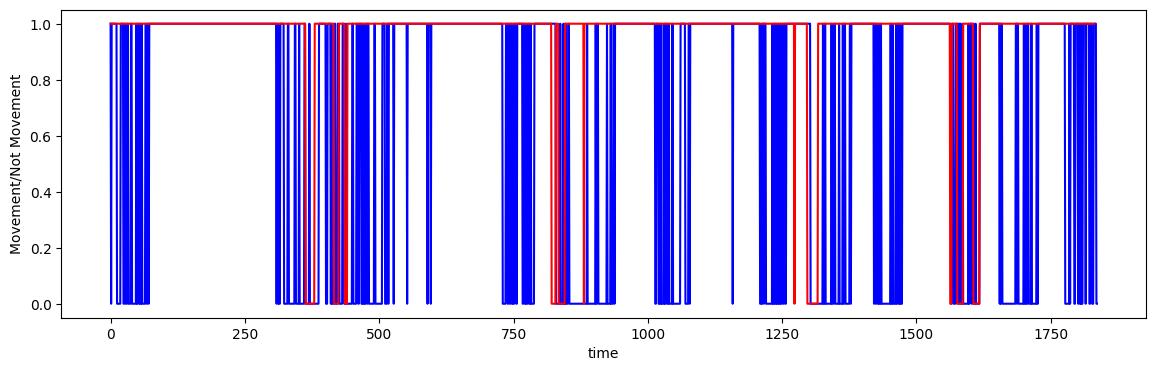

In [158]:
dfmoving = pd.DataFrame(data=moving)
dfpred_moving = pd.DataFrame(data=pred_moving)
plt.figure(figsize=(14,4),linewidth=.1)
plt.plot(dfmoving,'b') #compare one column at a time
plt.plot(dfpred_moving,'r')
plt.ylabel('Movement/Not Movement')
plt.xlabel('time');